#Plant classification

In this file we will go through the process of building a neural network from scratch to classify 4 different types of plants from the Soybean dataset.

#Data gathering
First we get the dataset

In [0]:
!wget https://data.mendeley.com/archiver/3fmjm7ncc6?version=2 -O soybean.zip

Then we unzip the file(s)

In [37]:
!unzip soybean.zip

unzip:  cannot find or open soybean.zip, soybean.zip.zip or soybean.zip.ZIP.


In [0]:
!unzip dataset.zip

Now we import the dependencies, that are needed. Please note, that this is mostly just numpy and pandas, since the main challenge is to create the neural network from scratch.

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import cv2
import glob

import os
for dirname, _, filenames in os.walk('/content/dataset'):
    for filename in filenames:
      print(os.path.join(dirname, filename));

Next we set up the basic functionality. We start with getting the classes for our problem.

In [41]:
data_dir = r'/content/dataset/' # Setting the dataset directory
classes=os.listdir(data_dir)
print(classes)

['soil', 'broadleaf', 'soybean', 'grass']


#Model preparation
Now we start setting up our X and Y, that will be used for our model.

In [0]:
num_file = 1100 # Number of files
all_files = []
num_data = num_file * len(classes)
Y = np.zeros(num_data) # Initialize all output values with 0

# Get the files
for i, cls in enumerate(classes):
  all_files += [f for f in glob.glob(data_dir + cls + '/*.tif')][:num_file]
  Y[i * num_file: (i + 1) * num_file] = i # Label all classes with int [0.. len(classes)]

image_width = 200
image_height = 200
image_channel = 3
dimension = image_width * image_height * image_channel

X = np.ndarray(shape=(num_data, image_width, image_height, image_channel), dtype=np.uint8) # Create a nd array

for i, file in enumerate(all_files):
  X[i] = cv2.resize(cv2.imread(file), (image_width, image_height)) # Add and load all images

First we initialize our test, train and validation sets and then we split our data these sets. We take the first 50 images for our test set, the next 50 for our validation set and the remaining files for our training set. 

In [0]:
X_test = np.empty(shape=(200, image_width, image_height, image_channel), dtype=np.uint8)
X_train = np.empty(shape=(4000, image_width, image_height, image_channel), dtype=np.uint8)
X_val = np.empty(shape=(200, image_width, image_height, image_channel), dtype=np.uint8)

Y_test = np.empty(200)
Y_train = np.empty(4000)
Y_val = np.empty(200)


for i, cls in enumerate(classes):
  X_test[50 * i: 50 * (i + 1)] = X[np.where(Y == i)[0][:50]]
  X_val[50 * i: 50 * (i + 1)] = X[np.where(Y == i)[0][50:100]]
  X_train[1000 * i: 1000 * (i + 1)] = X[np.where(Y == i)[0][100:]]

  Y_test[50 * i: 50 * (i + 1)] = i
  Y_val[50 * i: 50 * (i + 1)] = i
  Y_train[1000 * i: 1000 * (i + 1)] = i

Now that both X and Y have served their purpose, we can delete them in order to save memory, that we can instead use later for the actual training of our model.

In [0]:
del Y
del X

We now have create random indexes for our array with the length of X_train.shape[0]

In [0]:
train_indexes = np.random.permutation(X_train.shape[0])
X_train = X_train[train_indexes]
Y_train = Y_train[train_indexes].astype(int) 


We now reshape our data

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

A good idea for when writing / testing the code is to create a small dataset, that can be quickly supplied to the model. And we also create a bigger dataset of 500 images for development purposes.

In [0]:
X_tiny = X_train[100:110].astype('float64')
Y_tiny = Y_train[100:110].astype(int)
num_dev = 500
X_dev = X_train[0:num_dev].astype('float64')
Y_dev = Y_train[0:num_dev].astype(int)

#Model building

The first thing we need in our model is to compute the "mean" image, which is done by adding the values of all the images together per pixel and then dividing by the number of images. 

In [0]:
mean_image = np.mean(X_train, axis=0)


We now subract this mean image from all the images in the dataset.

In [64]:
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image 
X_dev -= mean_image
X_tiny -= mean_image

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


We know want to be able to plot some things, so we set up the things needed.

In [0]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We now want to be able to plot 4 images of each class

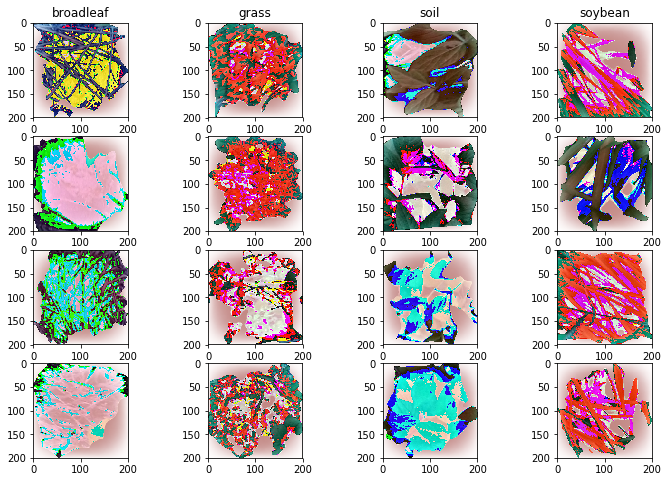

In [68]:
n_class = len(classes)
samples_per_class = 4

# Plot 4 images of each class
for Y, cls in enumerate(classes):
  indexes = np.flatnonzero(Y == Y_train)
  indexes = np.random.choice(indexes, samples_per_class, replace=False)
  for i, index, in enumerate(indexes):
    plt_index = i * n_class + Y + 1
    plt.subplot(samples_per_class, n_class, plt_index)
    plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))
    if i == 0: plt.title(cls)

plt.show()

#Defining the network

Here we create a class, that will be handling all our Neural Network code.
First we define our input and output sizes and we then set the size of hidden layers to be 200. And we set the number of epochs to be 500.

In [0]:
class NeuralNetwork:
  hidden_size = 200
  input_size = image_width * image_height * image_channel
  output_size = n_class

  """
  w1: first layer weight
  w2: second layer weight
  """
  w1 = 1e-3 * np.random.randn(input_size, hidden_size)
  b1 = np.zeros(hidden_size)
  w2 = 1e-3 * np.random.randn(hidden_size, output_size)
  b2 = np.zeros(output_size)
    
  alpha = 1e-5
  batch_size = 100
    
  epochs = 500
  
  def train(self, X, Y, X_val, Y_val):
    N, D = X.shape
    N_val = X_val.shape[0]
    iteration_per_epoch = max(N / self.batch_size, 1)

    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    
    for it in range(self.epochs):
      sampling = np.random.choice(np.arange(N), self.batch_size, replace=False) # Create random array data

      # Getting batches for x and y
      X_batch = X[sampling]
      Y_batch = Y[sampling]

      loss, grads = self.loss(X_batch, Y=Y_batch)
      loss_hist.append(loss)

      # Make the model learning and reshape the parameters of the network
      self.w1 += -1.0 * self.alpha * grads['w1']
      self.b1 += -1.0 * self.alpha * grads['b1']
      self.w2 += -1.0 * self.alpha * grads['w2']
      self.b2 += -1.0 * self.alpha * grads['b2']

      if it % 10 == 0:
        print('iteration: %d / %d | Loss: %f' % (it, self.epochs, loss))
    
      if it % iteration_per_epoch == 0:
        train_acc = (self.predict(X_batch) == Y_batch).mean()
        val_acc = (self.predict(X_val) == Y_val).mean()
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        self.alpha *= 0.95
    
    return {
        'loss_hist': loss_hist,
        'train_acc_hist': train_acc_hist,
        'val_acc_hist': val_acc_hist
    }

  def relu(self, z):
    return np.maximum(0, z)
  
  def predict(self, X):
    Y_pred = None
    layer1 = self.relu(X.dot(self.w1) + self.b1)
    scores = layer1.dot(self.w2) + self.b2
    Y_pred = np.argmax(scores, axis=1)
    return Y_pred

  def loss(self, X, Y = None):
    N, D = X.shape

    # Calculate the loss of our layer1
    layer1 = self.relu(X.dot(self.w1) + self.b1)
    scores = layer1.dot(self.w2) + self.b2

    if (Y is None):
      return scores

    # Calculate the actual loss
    scores -= scores.max()
    scores = np.exp(scores)
    scores_sumexp = np.sum(scores, axis=1)
    softmax = scores / scores_sumexp.reshape(N, 1)
    loss = -1.0 * np.sum(np.log(softmax[range(N), Y]))
    loss /= N

    grads = {}
    correct_class_scores = scores[range(N), Y]
    softmax[range(N), Y] = -1.0 * (scores_sumexp - correct_class_scores) / scores_sumexp
    softmax /= N

    grads['w2'] = layer1.T.dot(softmax)
    grads['b2'] = np.sum(softmax, axis=0)

    hidden = softmax.dot(self.w2.T)

    grads['w1'] = X.T.dot(hidden)
    grads['b1'] = np.sum(hidden, axis=0)

    return loss, grads

#Running the Neural Network on our data

In this we feed our data to the Neural Network, that we have defined in the previous section.

In [70]:
my_nn = NeuralNetwork()
stats = my_nn.train(X_dev, Y_dev, X_val, Y_val)

iteration: 0 / 500 | Loss: 1.443276
iteration: 10 / 500 | Loss: 1.336158
iteration: 20 / 500 | Loss: 1.291285
iteration: 30 / 500 | Loss: 1.232042
iteration: 40 / 500 | Loss: 1.200272
iteration: 50 / 500 | Loss: 1.145958
iteration: 60 / 500 | Loss: 1.110659
iteration: 70 / 500 | Loss: 1.125241
iteration: 80 / 500 | Loss: 1.068484
iteration: 90 / 500 | Loss: 1.029120
iteration: 100 / 500 | Loss: 1.027641
iteration: 110 / 500 | Loss: 0.993082
iteration: 120 / 500 | Loss: 0.963526
iteration: 130 / 500 | Loss: 1.029748
iteration: 140 / 500 | Loss: 0.951163
iteration: 150 / 500 | Loss: 0.945877
iteration: 160 / 500 | Loss: 0.960284
iteration: 170 / 500 | Loss: 0.948838
iteration: 180 / 500 | Loss: 0.974334
iteration: 190 / 500 | Loss: 0.980347
iteration: 200 / 500 | Loss: 0.960477
iteration: 210 / 500 | Loss: 0.987733
iteration: 220 / 500 | Loss: 0.891069
iteration: 230 / 500 | Loss: 0.966918
iteration: 240 / 500 | Loss: 0.904315
iteration: 250 / 500 | Loss: 0.945680
iteration: 260 / 500 | 

Now our training is done, but how good is our prediction? We calculating this by running the Neural Network on our test dataset, and we calculate how many times the prediction is equal to the actual label of the image.

In [71]:
print((my_nn.predict(X_test) == Y_test).mean())

0.625


Next we show two of the predicted images.

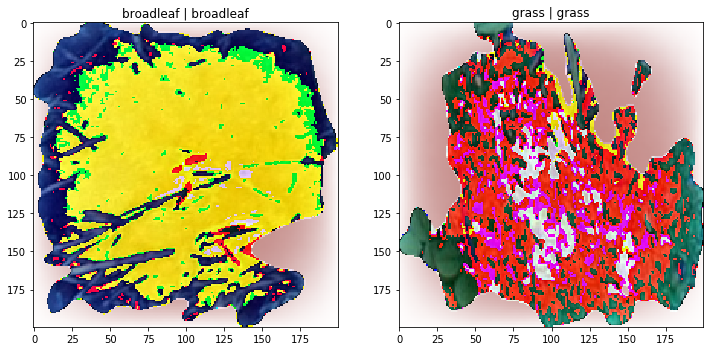

In [74]:
index = np.flatnonzero(0 == Y_train)
index = np.random.choice(index, 1, replace=False)
prediction = my_nn.predict(X_train[index])

plt.subplot(1, 2, 1)
plt.title('{} | {}'.format(classes[0], classes[prediction[0]]))
plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))

index = np.flatnonzero(1 == Y_train)
index = np.random.choice(index, 1, replace=False)
prediction = my_nn.predict(X_train[index])

plt.subplot(1, 2, 2)
plt.title('{} | {}'.format(classes[1], classes[prediction[0]]))
plt.imshow(X_train[index].reshape(image_width, image_height, image_channel).astype('uint8'))